# Prepare data

In [36]:
# Install the dependencies for this lab
!pip install -qU elasticsearch overturemaps geopandas matplotlib

# Data dir
WORK_DIR="./data"

## Get the data from Overturemaps Places dataset

Get Overturemaps Foundation Points of Interest (`places` dataset) using thir python library.

[Library](https://github.com/OvertureMaps/overturemaps-py/tree/main) | [Documentation](https://docs.overturemaps.org/guides/places/)  | [Reference](https://docs.overturemaps.org/schema/reference/places/place/)

In [37]:
%%time
import os
import io
import pandas as pd
import geopandas as gpd
from overturemaps import core

# Get different bounding boxes from http://bboxfinder.com
places = {
    "bosnia": { "bbox": [15.688477,41.873651,20.489502,45.278752]},
    "valencia": {"bbox": [-0.432243,39.419221,-0.296288,39.504306]},
    "belem": {"bbox": [-48.524294,-1.492160,-48.371258,-1.397691]}
}

# Create the data dir if not exists
if not os.path.exists(WORK_DIR):
    os.makedirs(WORK_DIR)

for key, value in places.items():
    places_path = os.path.join(WORK_DIR, f"places_{key}.parquet")
    # Only download if file does not exist
    if not os.path.isfile(path=places_path):

        # Download places (POI) from the Overturemaps parquet release
        # using the overture library
        print(f"Downloading data for {key}")
        gdf = core.geodataframe("place",bbox=value["bbox"])
        print(f"{len(gdf)} features downloaded into {places_path}")

        # Save the content into a file
        gdf.to_parquet(path=places_path)
    else:
        print(f"{places_path} already downloaded")

./data/places_bosnia.parquet already downloaded
./data/places_valencia.parquet already downloaded
./data/places_belem.parquet already downloaded
CPU times: user 195 µs, sys: 0 ns, total: 195 µs
Wall time: 169 µs


In [38]:
# Get the parquet files from disk as GeoDataFrames into a list
dataframes = []

for key in places.keys():
    places_path = os.path.join(WORK_DIR, f"places_{key}.parquet")
    places[key]["gdf"] = gpd.read_parquet(path=places_path)
    print(f"{len(places[key]['gdf'])} features loaded from {places_path}")


166644 features loaded from ./data/places_bosnia.parquet
36193 features loaded from ./data/places_valencia.parquet
27736 features loaded from ./data/places_belem.parquet


,0
id,284b4fcf-224a-438a-b665-9ca6f572d909
geometry,POINT (15.6921637 41.9091427)
bbox,"{'xmax': 15.69216537475586, 'xmin': 15.6921634..."
version,1
sources,"[{'between': None, 'confidence': 0.98792562183..."
names,"{'common': None, 'primary': 'Village Camping R..."
categories,"{'alternate': ['restaurant', 'accommodation'],..."
confidence,0.987926
websites,[http://www.rancho.it/]
socials,[https://www.facebook.com/48506552944]


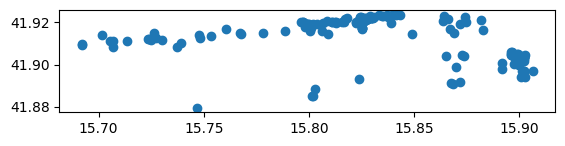

In [39]:
# See the first row and some points on a map
gdf = list(places.items())[0][1]["gdf"]
# See the first row and some points on a map
gdf.head(200).plot()
gdf.iloc[0]

## Connect to Elasticsearch

If running in Google Colab, get the Elastic cluster credentials from the session **Secrets**. Otherwise update the cell to use `os.getenv` to get details from environment variables, for example.

In [42]:
import os
from google.colab import userdata
from elasticsearch import Elasticsearch

# Login details
ES_URL=userdata.get('es_url_foss4ge')
KB_URL=userdata.get('kb_url_foss4ge')
ES_APIKEY=userdata.get('apikey_foss4ge')

In [43]:
# Create the Elasticsearch lient and print some cluster details
client = Elasticsearch(hosts=[ES_URL], api_key=ES_APIKEY)

c_info = client.info()
c_license = client.license.get()['license']
is_serverless = c_info['version']['build_flavor'] == 'serverless'

print(f"Elasticsearch URL: {ES_URL}")
print(f"Cluster name: {c_info['name']}")
print(f"Version: {c_info['version']['number'] if not is_serverless else 'serverless'}")
print(f"License is {c_license.get('status')} and on **{c_license.get('type')}** until **{c_license.get('expiry_date', 'N/A')}**")

Elasticsearch URL: https://foss4geurope.es.us-central1.gcp.cloud.es.io
Cluster name: instance-0000000000
Version: 9.0.3
License is active and on **enterprise** until **2028-02-29T23:59:59.999Z**


## Connect to Kibana

In [44]:
import requests
import json
from functools import partial

session = requests.Session()
kibana_headers = {
    "kbn-xsrf": "true",
    "Content-Type": "application/json",
    "Authorization": f"ApiKey {ES_APIKEY}"
    }

# Helper functions to just pass API paths and data
def kib_get(path):
    return session.get(f"{KB_URL}{path}", headers=kibana_headers)
def kib_put(path, data):
    return session.put(f"{KB_URL}{path}",
                       headers=kibana_headers,
                       data=json.dumps(data))
def kib_post(path, data):
    return session.post(f"{KB_URL}{path}",
                        headers=kibana_headers,
                        data=json.dumps(data))

In [45]:
# Check the status
print(f"Kibana URL: {KB_URL}")
k_status = kib_get("/api/status").json()
if 'status' in k_status:
    print(json.dumps(k_status['status']['overall'], indent=2))
else:
    print("Kibana is not available")

Kibana URL: https://foss4geurope.kb.us-central1.gcp.cloud.es.io
{
  "level": "available",
  "summary": "All services and plugins are available"
}


In [46]:
# Optional: change default space to Search type (simpler UI)
desired_solution = "es"

# Get the default space data
default_space = kib_get("/api/spaces/space/default").json()

if not is_serverless:
    # If a solution is not defined or the desired, change it
    solution = default_space.get("solution", False)
    if solution != desired_solution:
        payload = {
            "id": default_space["id"],
            "name": default_space["name"],
            "solution": desired_solution
        }

        # Modify the Space with the new solution
        r_space = kib_put("/api/spaces/space/default", data=payload)
        r_space_json = r_space.json()
        print(f"Space is now a '{r_space_json.get('solution')}' type")
    else:
        print("Space is already a search type")
else:
    print("Serverless projects can't set up Spaces solutions")

Space is already a search type


## Upload the Overturemaps datasets

In [47]:
# Define an index template for places indices
index_shards = 1
index_replicas = 0 if ES_URL.startswith("http://elasticsearch") else 1

component_template_body = {
    "mappings": {
        "properties": {
            "id": {"type": "text"},
            "geometry": {"type": "geo_point"},
            "version": {"type": "integer"},
            "source": {"type": "keyword"},
            "confidence": {"type": "float"},
            "name": {"type": "text"},
            "category": {"type": "keyword"},
            "alt_categories": {"type": "keyword"},
            "websites": {"type": "text"},
            "socials": {"type": "text"},
            "emails": {"type": "text"},
            "phones": {"type": "text"},
            "brand": {"type": "keyword"},
            "addresses": {
                "properties": {
                    "country": {"type": "keyword"},
                    "freeform": {"type": "text"},
                    "locality": {"type": "keyword"},
                    "postcode": {"type": "keyword"},
                    "region": {"type": "keyword"},
                }
            },
            "updated": {"type": "date"}
        }
    }
}

# Self-hosted allow to set up shards and replica settings
if not is_serverless:
    component_template_body["settings"] = {
        "number_of_shards": index_shards,
        "number_of_replicas": index_replicas
    }

# Create a template that automatically configures indices named as places*
client.indices.put_index_template(
    name="overturemaps-places",
    index_patterns="places-*",
    template=component_template_body)

ObjectApiResponse({'acknowledged': True})

In [48]:
# Generator funcion to yield documents to upload to ES
def generate_actions(gdf):
    for index, doc in gdf.iterrows():
        yield {
            "_index": index_name,
            "_id": doc["id"],
            "_source": {
                "id": doc["id"],
                "geometry": str(doc["geometry"]),
                "version": doc["version"],
                "source": [s.get("dataset",None) for s in doc.get("sources",[])],
                "name": doc.get("names").get("primary", None) if "names" in doc else None,
                "category": doc.get("categories").get("primary", None) if "categories" in doc else None,
                "alt_categories": doc.get("categories").get("alternate", []),
                "brand": doc.get("brand").get("primary",None) if doc.get("brand", None) is not None else None,
                "websites": doc.get("websites",[]),
                "socials": doc.get("socials",[]),
                "emails": doc.get("emails",[]),
                "phones": doc.get("phones",[]),
                "addresses": doc.get("addresses",[]),
                "updated": [s.get('update_time') for s in doc.get('sources')][0],
                "confidence": [s.get('confidence') for s in doc.get('sources')][0],
            }
        }

In [49]:
%%time
from elasticsearch import helpers
import time

DELETE_INDEX=False

# Iterate over the geodataframes to create
# one index per parquet file
for key, value in places.items():
    index_name = f"places-{key}"
    print(f"Start processing {index_name}")

    # Remove the index if necessary
    if client.indices.exists(index=index_name):
        if DELETE_INDEX:
            print(f"Deleting previous index {index_name}")
            client.indices.delete(index=index_name)
        else:
            print("Index is present, skipping upload")

    if not client.indices.exists(index=index_name):
        # Create the index with the correct mappings and properties
        client.indices.create(index=index_name)

        # Perform the bulk ingestion
        print(f"Starting ingestion into {index_name}...")
        start_time = time.time()
        success_count, errors = helpers.bulk(
            client,
            generate_actions(value["gdf"]),
            stats_only=True
        )
        end_time = time.time()

        print(f"Bulk ingestion completed in {end_time - start_time:.2f} seconds.")
        print(f"Successfully indexed: {success_count} documents.")
        if errors:
            print(f"Errors encountered: {len(errors)}")
            # print("First few errors:", errors[:5]) # Uncomment to see actual errors

        # (Optional) Refresh the index to make documents searchable immediately
        # This is usually done for testing/development. For production, rely on refresh_interval.
        refresh = client.indices.refresh(index=index_name)
        if refresh.get("_shards",{}).get("successful",0) == 1:
            print("Index refresh successful")

        print("-----------------------------------")

Start processing places-bosnia
Index is present, skipping upload
Start processing places-valencia
Index is present, skipping upload
Start processing places-belem
Index is present, skipping upload
CPU times: user 22.3 ms, sys: 1.06 ms, total: 23.3 ms
Wall time: 273 ms


In [50]:
# Create a Kibana data view for the places-* pattern
payload = {
    "data_view": {
        "name": "Overturemaps Places",
        "title": "places-*",
        "timeFieldName": "update_time"
  }
}
# Add the data view using the Kibana API
r_dataview = kib_post("/api/data_views/data_view", data=payload).json()

if 'data_view' in r_dataview:
    print("Data view created!")
else:
    print("Data view not created")
    print(f"Message: {r_dataview['message']}")

Data view not created
Message: Duplicate data view: Overturemaps Places


In [51]:
# Verify ingestion by searching in places-*
print("Verifying document count in all places indices':")
try:
    count_response = client.count(index="places-*")
    print(f"Documents places-*: {count_response['count']}")
except Exception as e:
    print(f"Error verifying documents: {e}")


print("\nSearching for documents in places-* with names...")
try:
    response = client.search(
        index="places-*",
        query={"bool": {"filter": {"exists": {"field": "name"}}}},
        size=10
    )

    # Process the search results
    if response['hits']['total']['value'] > 0:
        for hit in response['hits']['hits']:
            print(f"[{hit['_index']}] {hit['_source']['name']} [{hit['_source']['category']}]")
    else:
        print("No documents found in the index.")

except Exception as e:
    print(f"Error during search: {e}")

Verifying document count in all places indices':
Documents places-*: 230573

Searching for documents in places-* with names...
[places-belem] Depyl Action [hair_removal]
[places-belem] Salão Atrevida [beauty_salon]
[places-belem] Clínica Carolini Carneiro Estética & Neopilates [beauty_salon]
[places-belem] Edificio Ipê [landmark_and_historical_building]
[places-belem] Bar e Restaurante Parrilha [bar]
[places-belem] Condomínio do Edifício Ipê Matriz [landmark_and_historical_building]
[places-belem] papamassado [automotive_repair]
[places-belem] Edifício Francisca Julia [landmark_and_historical_building]
[places-belem] Elas no Civil [lawyer]
[places-belem] Salão SR Fashion [beauty_salon]


## Download and ingest Countries data

In [52]:
# Download and uncompress the NaturalEarth countries dataset
from io import BytesIO
import zipfile

ne_countries_shp = "data/ne_10m_admin_0_countries.shp"

try:
    if not os.path.exists(ne_countries_shp):
        url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
        extract_to = "data/"
        print(f"Downloading zip file from: {url}")
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

        # Create a BytesIO object from the response content
        zip_file_in_memory = BytesIO(response.content)

        print(f"Extracting contents to: {os.path.abspath(extract_to)}")
        # Create the extraction directory if it doesn't exist
        os.makedirs(extract_to, exist_ok=True)

        with zipfile.ZipFile(zip_file_in_memory, 'r') as zf:
            zf.extractall(extract_to)
        print("Zip file successfully downloaded and uncompressed.")
    else:
        print("data/ne_10m_admin_0_countries.shp ready to use")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


data/ne_10m_admin_0_countries.shp ready to use


In [53]:
gdf = gpd.GeoDataFrame.from_file(ne_countries_shp)

# Simplify the geometries before uploading
gdf['geometry'] = gdf['geometry'].simplify(0.0001, preserve_topology=True)

In [62]:
# Select the columns to ingest as field mappings
component_template_body = {
    "mappings": {
        "properties": {
            "id": {"type": "text"},
            "geometry": {"type": "geo_shape"},
            "type": {"type": "keyword"},
            "name": {"type": "text"},
            "iso_a2": {"type": "keyword"},
            "iso_a3": {"type": "keyword"},
            "continent": {"type": "keyword"},
            "region_un": {"type": "keyword"},
            "subregion": {"type": "keyword"},
            "economy": {"type": "keyword"},
            "income_grp": {"type": "keyword"},
            "pop_est": {"type": "integer"},
            "gdp_md": {"type": "integer"},
        }
    }
}

# Self-hosted allow to set up shards and replica settings
if not is_serverless:
    component_template_body["settings"] = {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "index.mode": "lookup"
    }

# Create a template that automatically configures indices named as places*
client.indices.put_index_template(
    name="overturemaps-places",
    index_patterns="ne_countries",
    template=component_template_body)

ObjectApiResponse({'acknowledged': True})

In [63]:
# Generator funcion to yield documents to upload to ES
def generate_actions(gdf):
    for index, doc in gdf.iterrows():
        yield {
            "_index": index_name,
            "_source": {
                "id": doc["WOE_ID_EH"],
                "geometry": str(doc["geometry"]),
                "type": doc["TYPE"],
                "name": doc["NAME"],
                "iso_a2": doc["ISO_A2_EH"],
                "iso_a3": doc["ISO_A3_EH"],
                "continent": doc["CONTINENT"],
                "region_un": doc["REGION_UN"],
                "subregion": doc["SUBREGION"],
                "economy": doc["ECONOMY"],
                "income_grp": doc["INCOME_GRP"],
                "pop_est": doc["POP_EST"],
                "gdp_md": doc["GDP_MD"],
            }
        }

In [64]:
%%time
from elasticsearch import helpers
import time

DELETE_INDEX=True

index_name = "ne_countries"
print(f"Start processing {index_name}")

# Remove the index if necessary
if client.indices.exists(index=index_name):
    if DELETE_INDEX:
        print(f"Deleting previous index {index_name}")
        client.indices.delete(index=index_name)
    else:
        print("Index is present, skipping upload")

if not client.indices.exists(index=index_name):
    # Create the index with the correct mappings and properties
    client.indices.create(index=index_name)

    # Perform the bulk ingestion
    print(f"Starting ingestion into {index_name}...")
    start_time = time.time()
    success_count, errors = helpers.bulk(
        client,
        generate_actions(gdf),
        stats_only=True,
        chunk_size=50,
        raise_on_error=False
    )
    end_time = time.time()

    print(f"Bulk ingestion completed in {end_time - start_time:.2f} seconds.")
    print(f"Successfully indexed: {success_count} documents.")
    if errors:
        print(errors)
        # print(f"Errors encountered: {len(errors)}")
        # print("First few errors:", errors[:5]) # Uncomment to see actual errors

    # (Optional) Refresh the index to make documents searchable immediately
    # This is usually done for testing/development. For production, rely on refresh_interval.
    refresh = client.indices.refresh(index=index_name)
    if refresh.get("_shards",{}).get("successful",0) == 1:
        print("Index refresh successful")

    print("-----------------------------------")

Start processing ne_countries
Deleting previous index ne_countries
Starting ingestion into ne_countries...
Bulk ingestion completed in 4.84 seconds.
Successfully indexed: 257 documents.
1
Index refresh successful
-----------------------------------
CPU times: user 993 ms, sys: 40 ms, total: 1.03 s
Wall time: 5.27 s


In [57]:
# Create a Kibana data view for the places-* pattern
payload = {
    "data_view": {
        "name": "NaturalEarth Countries",
        "title": index_name
  }
}
# Add the data view using the Kibana API
r_dataview = kib_post("/api/data_views/data_view", data=payload).json()

if 'data_view' in r_dataview:
    print("Data view created!")
else:
    print("Data view not created")
    print(f"Message: {r_dataview['message']}")

Data view not created
Message: Duplicate data view: NaturalEarth Countries


In [58]:
# Verify ingestion by searching in places-*
print(f"\nVerifying document count:")
try:
    count_response = client.count(index=index_name)
    print(f"Documents places-*: {count_response['count']}")
except Exception as e:
    print(f"Error verifying documents: {e}")


print(f"\nSearching for countries of type Lease...")
try:
    response = client.search(
        index=index_name,
        query={"term":{"type":{"value": "Lease"}}},
        size=10
    )

    # Process the search results
    if response['hits']['total']['value'] > 0:
        for hit in response['hits']['hits']:
            print(f"[{hit['_index']}] {hit['_source']['name']} [{hit['_source']['name']}]")
    else:
        print("No documents found in the index.")

except Exception as e:
    print(f"Error during search: {e}")


Verifying document count:
Documents places-*: 257

Searching for countries of type Lease...
[ne_countries] USNB Guantanamo Bay [USNB Guantanamo Bay]
[ne_countries] Baikonur [Baikonur]


In [65]:
response['hits']['hits']

[{'_index': 'ne_countries',
  '_id': 'voCF75cBohZBeIWsd7Ho',
  '_score': 4.6366687,
  '_source': {'id': -99,
   'geometry': 'MULTIPOLYGON (((-75.0950058107462 19.897225962598796, -75.10766111999993 19.89759226600006, -75.13742489299995 19.892553732000067, -75.16191957099994 19.891142236000064, -75.16529607899992 19.897012390000043, -75.16437767299993 19.91371929400009, -75.15766315899992 19.91870416000006, -75.14647376199991 19.92340729400007, -75.12263792099992 19.94046066100009, -75.11784056199991 19.944083637000062, -75.10438848599995 19.94275725300008, -75.10104154399994 19.953149818000043, -75.10460215699993 19.959358803000043, -75.11675834999994 19.967054234000045, -75.12986191999994 19.95561256600007, -75.13380559799992 19.958074399000054, -75.13963782499991 19.964992580000057, -75.13703578043308 19.971550610171906, -75.09495029099989 19.971583690000003, -75.0950058107462 19.897225962598796)), ((-75.1601924439999 19.970647995000036, -75.16835286299994 19.96656475000009, -75.1712

## Checking for a missing document

We indexed `257` document but our Natural Earth dataset has `258` document. What is missing? Why?

In [59]:
# Lets get the countries in our index
es_names_docs=client.search(
    index=index_name,
    query={"match_all": {}},
    _source_includes=False,
    fields=["name"],
    size=1000
)
es_countries = set([hit['fields']['name'][0] for hit in es_names_docs["hits"]["hits"]])
print(f"There are {len(es_countries)} different countries in our ES index")


# And a set from the "WOE_ID_EH" in the DataFrame
gdf_countries = set(gdf["NAME"])
print(f"There are {len(gdf_countries)} different countries in the Natural Earth DataFrame")

There are 257 different countries in our ES index
There are 258 different countries in the Natural Earth DataFrame


In [60]:
# Let's substract the sets to get the missing country
gdf_countries - es_countries

{'Antarctica'}

In [61]:
# Antarctica was not indexed in our bulk process, let's try to index it manually
from elasticsearch.exceptions import BadRequestError

# Get the Antarctica row
antarctica = gdf[gdf['NAME'] == 'Antarctica'].copy()

# Try the classic buffer-zero fix
antarctica["geometry"] = antarctica["geometry"].buffer(0)
doc = antarctica.iloc[0]

# Try to manually index that geometry
try:
    client.index(
        index="ne_countries",
        document={"geometry": str(doc["geometry"]),"name": doc["NAME"]}
    )
except BadRequestError as e:
    print(json.dumps(e.info, indent=2))

{
  "error": {
    "root_cause": [
      {
        "type": "document_parsing_exception",
        "reason": "[1:13] failed to parse field [geometry] of type [geo_shape]"
      }
    ],
    "type": "document_parsing_exception",
    "reason": "[1:13] failed to parse field [geometry] of type [geo_shape]",
    "caused_by": {
      "type": "illegal_argument_exception",
      "reason": "Polygon self-intersection at lat=-84.3517829528102 lon=-163.03271507289995"
    }
  },
  "status": 400
}
